# Training Procedure

Imports básicos.

In [0]:
import os
import numpy as np
import torch

import PIL

from sklearn import datasets

from skimage import io

## Setting data loader

Criando um dataloader customizado para o dataset Olivetti. Para mais informações sobre o dataset, acesse a página: <https://scikit-learn.org/0.19/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces>.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to ./
Training features: (320, 4096)
Training labels: (320,)
Test features: (80, 4096)
Test labels: (80,)
(tensor([-0.2288, -0.2288, -0.2288,  ...,  0.3178,  0.2703,  0.2941]), tensor(4))
(tensor([-0.2763, -0.0149,  0.1990,  ..., -2.1300, -2.1538, -2.1538]), tensor(0))


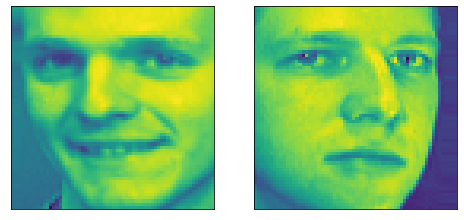

In [2]:
from torch.utils.data import DataLoader
from torch.utils import data

from matplotlib import pyplot as plt

%matplotlib inline

# Creating custom dataloader.
class CustomDataset(data.Dataset):

    def __init__(self, mode):
        
        super(CustomDataset, self).__init__()
        
        # Initializing variables.
        self.mode = mode

        # Creating dataset from sklean.
        self.make_dataset()

    def make_dataset(self):

        # Downloading (if needed) dataset and getting features/labels.
        faces = datasets.fetch_olivetti_faces(data_home='./',
                                              download_if_missing=True,
                                              return_X_y=False)

        # Dividing between training and testing sets.
        np.random.seed(1234) # Setting random seed for numpy.
        perm = np.random.permutation(faces.data.shape[0])

        if self.mode == 'train':
            
            # Slicing training data/labels.
            self.X = faces.data[perm[:int(0.8 * perm.shape[0])]] # Perm.
            self.Y = faces.target[perm[:int(0.8 * perm.shape[0])]] # Perm.
            # self.X = faces.data[:int(0.8 * perm.shape[0])] # No perm.
            # self.Y = faces.target[:int(0.8 * perm.shape[0])] # No perm.
            
            # Computing average and standard deviation from training set.
            self.avg = self.X.mean()
            self.std = self.X.std()
            
            # Printing dataset size.
            print('Training features: ' + str(self.X.shape))
            print('Training labels: ' + str(self.Y.shape))

        elif self.mode == 'test':
            
            # Slicing training data/labels (for computing avg and std).
            X_train = faces.data[perm[:int(0.8 * perm.shape[0])]] # Perm.
            Y_train = faces.target[perm[:int(0.8 * perm.shape[0])]] # Perm.
            # X_train = faces.data[:int(0.8 * perm.shape[0])] # No perm.
            # Y_train = faces.target[:int(0.8 * perm.shape[0])] # No perm.
            
            # Computing average and standard deviation from training set.
            self.avg = X_train.mean()
            self.std = X_train.std()
            
            # Slicing test data/labels.
            self.X = faces.data[perm[int(0.8 * perm.shape[0]):]] # Perm.
            self.Y = faces.target[perm[int(0.8 * perm.shape[0]):]] # Perm.
            # self.X = faces.data[int(0.8 * perm.shape[0]):] # No perm.
            # self.Y = faces.target[int(0.8 * perm.shape[0]):] # No perm.
            
            # Printing dataset size.
            print('Test features: ' + str(self.X.shape))
            print('Test labels: ' + str(self.Y.shape))

    def __getitem__(self, index):
        
        # Recovering sample and label according to index.
        data = self.X[index]
        label = self.Y[index]
        
        # Normalizing data.
        data = (data - self.avg) / self.std
        
        # Turning data to Pytorch tensors.
        data = torch.from_numpy(data.astype(np.float32))
        label = torch.from_numpy(np.asarray(label, dtype=np.long))
        
        # Returning data and label to iterator.
        return data, label

    def __len__(self):

        return self.X.shape[0]

# Instancing training and testing sets.
train_set = CustomDataset('train')
test_set = CustomDataset('test')

# Printing/plotting samples.
print(train_set[0])
print(test_set[0])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(train_set[0][0].reshape(64, 64))
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].imshow(test_set[0][0].reshape(64, 64))
ax[1].set_yticks([])
ax[1].set_xticks([])

plt.show()

In [3]:
# Creating data loaders.
batch_size = 1000

train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for i, data in enumerate(train_loader):
    
    inps, labs = data
    print(inps.size(), labs.size())
    print('')

    if i > 5:
        break

torch.Size([320, 4096]) torch.Size([320])



## Setting architecture

Defina a arquitetura da sua Rede Neural. O pacote torch.nn que contém as implementações de todas as camadas que serão usadas nessa parte (nn.Linear): <https://pytorch.org/docs/stable/nn.html>.

In [9]:
import torch.nn as nn

# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

# Customized Network.
class CustomNetwork(nn.Module):
    
    def __init__(self, input_size, n_classes):

        super(CustomNetwork, self).__init__()
        
        '''
        Exercício 1.1: crie uma Rede Neural totalmente conectada com 1 camada
        escondida que faça classificação das amostras do dataset Olivetti. 
        Essa camada escondida deve receber o tamanho input_size (4096 para o
        Olivetti) e gerar n_classes de saída (40 para o Olivetti).
        '''
        ###################################################
        # Neural Network architecture. 1 hidden layer. ####
        ###################################################
        self.n_outputs_1 = n_classes # n classes de saída

        self.layer1 = nn.Linear(input_size, self.n_outputs_1) # Fully Connected Layer: 4096 -> 40
        # One hidden layer

        '''
        Exercício 5.1: expanda sua Rede Neural totalmente conectada para que ela
        tenha uma capacidade maior (mais parâmetros). Sua rede deve ter entre 2
        e 4 camadas escondidas e ir diminuindo o número de features
        progressivamente ao longo essas camadas. Cada camada intermediária deve
        receber o output da última camada. A primeira camada deve receber
        input_size features e a última camada deve gerar n_classes features que
        farão as predições entre as classes do Olivetti. Adicione ativações ReLU
        após todas as camadas nn.Linear, menos na última, que não deve ter
        nenhuma ativação.
        '''
        # ###################################################
        # # Neural Network architecture. 2~4 hidden layers. #
        # ###################################################
        # self.n_outputs_1 = 1000
        # self.n_outputs_2 = 500
        # self.n_outputs_3 = 100

        # self.drop = nn.Dropout()                                    # Reusable Dropout regularization layer.

        # self.layer1 = nn.Linear(input_size, self.n_outputs_1)       # Criar primeira camada linear. Fully Connected Layer: 4096 -> 1000.
        # self.ativ1 = nn.ReLU(inplace = True)                        # Criar ativação da primeira camada - ReLU
        
        # self.layer2 = nn.Linear(self.n_outputs_1, self.n_outputs_2) # Fully Connected Layer: 1000 -> 500.
        # self.ativ2 = nn.ReLU(inplace=True)                          # ReLU Activation Layer.
        
        # self.layer3 = nn.Linear(self.n_outputs_2, self.n_outputs_3) # Fully Connected Layer: 500 -> 100.
        # self.ativ3 = nn.ReLU(inplace=True)                          # ReLU Activation Layer.
        
        # self.layer4 = nn.Linear(self.n_outputs_3, n_classes)        # Fully Connected Layer: 100 -> 40.

    # Forward function.
    def forward(self, x):

        '''
        Exercício 1.2: Alimente os dados para a camada da sua rede. Para
        alimentar um dado x para uma certa camada self.camada_n:
        saida = self.camada_n(x).
        '''
        ###################################################
        # Forwarding through the single hidden layer. #####
        ###################################################
        out = self.layer1(x) # Passar o input x pela camada self.layer1.

        '''
        Exercício 5.2: Atualize a sua função forward para a nova arquitetura da
        sua rede com mais de uma camada.
        '''
        # ###################################################
        # # Forwarding through all layers. ##################
        # ###################################################
        # out = self.layer1(x)   # Passar o input x sequencialmente pelas camadas da rede.
        # out = self.drop(self.ativ1(out))


        # out2 = self.layer2(out)   # Camada 2
        # out2 = self.drop(self.ativ2(out2))


        # out3 = self.layer3(out3)   # Camada 3
        # out3 = self.drop(self.ativ3(out3))


        # out4 = self.layer4(out3)   # Camada 4



        # Returning output.
        return out  # Retornar a saída da última camada.
        #return out4 # quando utilizar multilayers

        
# Instancing Network.
input_size = 4096 # Input size (number of features).
n_classes = 40 # Number of classes.

# model = CustomNetwork(input_size) # CPU version.
model = CustomNetwork(input_size, n_classes).cuda() # GPU casting.

initialize_weights(model)

# Printing NN.
print(model)

CustomNetwork(
  (layer1): Linear(in_features=4096, out_features=40, bias=True)
)


## Setting optimizer

O $Pytorch$ tem várias opções de otimizadores, desde os mais simples como o SGD até adaptadores mais modernos com velocidades de aprendizado adaptáveis para cada parâmetro da rede (i.e. Adam, Adagrad, RSMProp...). Todos os otimizadores estão localizados no pacote torch.optim. Para mais informnações sobre o pacote, visite: <https://pytorch.org/docs/stable/optim.html>.

In [5]:
import torch.optim as optim

lr = 0.01 # learning rate - define o 'passo' de otimização
l2_normalization = 0.00005 # L2 Normalization via weight decay.

'''
Exercício 2: defina um otimizador. Comece pelo mais básico: o SGD. Experimente
diferentes learning rates para o otimizador e observe como isso afeta a
otimização da loss durante o treinamento/teste.
'''
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = l2_normalization) # otimizador SGD


'''
Exercício 6: utilize um otimizador mais poderoso como o Adam. Note que ele
possui parâmetros levemente diferentes do SGD.
'''
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = l2_normalization, betas)

'\nExercício 6: utilize um otimizador mais poderoso como o Adam. Note que ele\npossui parâmetros levemente diferentes do SGD.\n'

## Setting loss criterion

Definindo um critério (loss) de classificação para calcular o erro do seu modelo a cada batch de amostras. A $CrossEntropyLoss$ ou a $NLLLoss$ são funções de perda indicadas para esse tipo de tarefa. Informações sobre essas losses podem ser encontradas em: <https://pytorch.org/docs/stable/nn.html#loss-functions>. 

In [0]:
# Setting classification loss.
'''
Exercício 3: Defina uma loss function. Lembre-se de fazer o casting da loss para
a GPU assim como fizemos na rede.
'''
criterion = nn.CrossEntropyLoss().cuda() #CrossEntropyLoss, cuda() = GPU
#criterion = nn.NLLLoss().cuda() #NLLLoss

## Training/Testing

Iterando sobre batches de treino e teste ao longo de várias epochs.

In [7]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

%matplotlib inline

epochs = 20 # Number of training and testing epochs.

training_metrics = list() # List for accuracies in training procedure.
test_metrics = list() # List for accuracies in test procedure.

# Iterating over epochs.
for ep in range(epochs):
    
    print('##############################################')
    print('Starting epoch ' + str(ep + 1) + '/' + str(epochs) + '...')
    
    #####################################################################
    # Training Procedure. ###############################################
    #####################################################################
    
    print('    Training...')
    
    # Setting model to training mode.
    model.train()
    
    # Iterating over training batches.
    for it, data in enumerate(train_loader):

        # Obtaining data and labels for batch.
        inps, labs = data
        
        # GPU casting. In CPU version comment the following two lines.
        inps = inps.cuda()
        labs = labs.cuda()
        
        # Zeroing optimizer.
        optimizer.zero_grad()
        
        '''
        Exercício 4: faça o forward do dado através da rede (de modo parecido
        com o que foi feito na função forward). Com os outputs gerados pela
        rede, calcule a loss para o mini-batch atual de acordo com o criterion
        previamente definido. Lembre-se de fazer a mesma
        coisa no procedimento de teste.
        '''
        # Forwarding inps through NN.
        output =  model(inps) #Passar os inputs através da rede.
        
        # Computing loss according to network prediction for batch and targets.
        loss = criterion(output, labs)# Calcular a loss de acordo com o criterion previamente definido.
        
        # Backpropagating loss.
        loss.backward()
        
        # Taking optimization step (updating NN weights).
        optimizer.step()
        
        # Appending metric for batch.
        training_metrics.append(loss.mean())

    #####################################################################
    # Testing Procedure.  ###############################################
    #####################################################################
    
    print('    Testing...')
    
    # Setting model to evaluation mode.
    model.eval()

    with torch.no_grad():

        label_list = list()
        output_list = list()

        # Iterating over test batches.
        for it, data in enumerate(test_loader):
            
            # Obtaining images and labels for batch.
            inps, labs = data
            
            # GPU casting. In CPU version comment the following line.
            inps = inps.cuda()
            labs = labs.cuda()
            
            # Forwarding through NN.
            output = model(inps) #Passar os inputs através da rede.
            
            # Computing loss according to network prediction for batch and targets.
            loss = criterion(output, labs) # Calcular a loss de acordo com o criterion previamente definido.

            # Appending metric for batch.
            test_metrics.append(loss.mean())

            # Getting labels and predictions from last epoch.
            label_list += labs.cpu().numpy().tolist()
            output_list += output.max(1)[1].cpu().numpy().tolist()

        label_array = np.asarray(label_list, dtype=np.int).ravel()
        output_array = np.asarray(output_list, dtype=np.int).ravel()

        print('Epoch: %d, Accuracy: %.2f%%' % (ep + 1, 100.0 * np.sum(label_array == output_array) / float(label_array.shape[0])))

##############################################
Starting epoch 1/20...
    Training...
    Testing...
Epoch: 1, Accuracy: 5.00%
##############################################
Starting epoch 2/20...
    Training...
    Testing...
Epoch: 2, Accuracy: 3.75%
##############################################
Starting epoch 3/20...
    Training...
    Testing...
Epoch: 3, Accuracy: 6.25%
##############################################
Starting epoch 4/20...
    Training...
    Testing...
Epoch: 4, Accuracy: 8.75%
##############################################
Starting epoch 5/20...
    Training...
    Testing...
Epoch: 5, Accuracy: 11.25%
##############################################
Starting epoch 6/20...
    Training...
    Testing...
Epoch: 6, Accuracy: 15.00%
##############################################
Starting epoch 7/20...
    Training...
    Testing...
Epoch: 7, Accuracy: 20.00%
##############################################
Starting epoch 8/20...
    Training...
    Testing...
Epoch: 

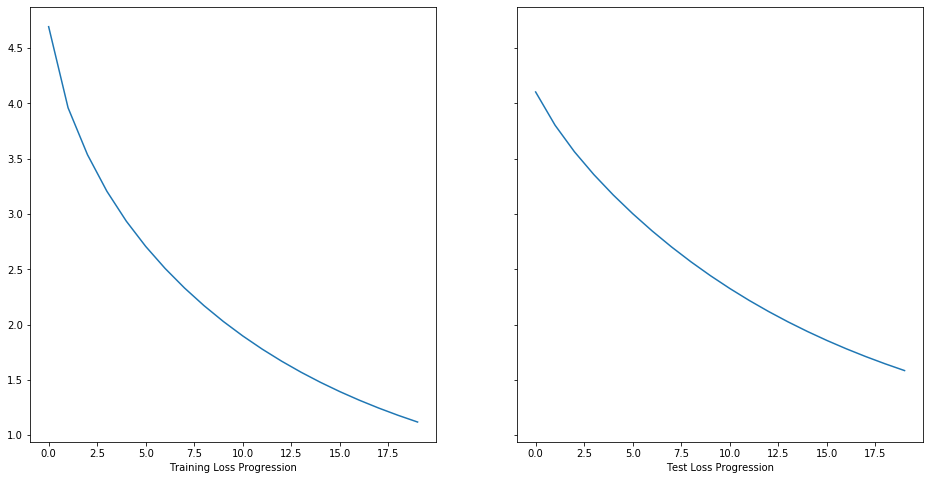

Actual: 0.0000, Predicted: 0.0000
Actual: 28.0000, Predicted: 28.0000
Actual: 1.0000, Predicted: 1.0000
Actual: 3.0000, Predicted: 17.0000
Actual: 17.0000, Predicted: 17.0000
Actual: 24.0000, Predicted: 24.0000
Actual: 4.0000, Predicted: 34.0000
Actual: 23.0000, Predicted: 23.0000
Actual: 36.0000, Predicted: 36.0000
Actual: 13.0000, Predicted: 13.0000


In [8]:
# Transforming list into ndarray for plotting.
training_array = np.asarray(training_metrics, dtype=np.float32)
test_array = np.asarray(test_metrics, dtype=np.float32)

# Plotting error metric.
fig, ax = plt.subplots(1, 2, figsize = (16, 8), sharex=False, sharey=True)

ax[0].plot(training_array)
ax[0].set_xlabel('Training Loss Progression')

ax[1].plot(test_array)
ax[1].set_xlabel('Test Loss Progression')

plt.show()

for i in range(10):
    print('Actual: %.4f, Predicted: %.4f' % (label_array[i], output_array[i]))